------------------------------------------------------------------------

Copyright 2023 Benjamin Alexander Albert \[Karchin Lab\]

All Rights Reserved

BigMHC Academic License

makefigs.ipynb

------------------------------------------------------------------------

In [1]:
import os
import sys

import matplotlib
import matplotlib.pyplot as plt

import colorsys

import pandas as pd

import numpy as np

import seaborn as sns

from sklearn import metrics

sys.path.append(os.path.join(os.pardir, "src"))

from metrics import auroc, auprc


sns.set_context("paper", font_scale=1.5)

style="whitegrid"
rc={"axes.facecolor": "0.99",
    "grid.color": "0.95",
    "axes.edgecolor": "0.90"}

datadir = os.path.join(os.pardir, "data")
dataoutdir = os.path.join(datadir, "out")
savedir = "figs"

if not os.path.exists(savedir):
    os.makedirs(savedir)

print("reading data...", end="")
pseudoseqs = pd.read_csv(os.path.join(datadir, "pseudoseqs.csv"))
eltrainval = pd.read_csv(os.path.join(dataoutdir, "el_trainval.csv"))
imtrainval = pd.read_csv(os.path.join(dataoutdir, "im_trainval.csv"))
eltest = pd.read_csv(os.path.join(datadir, "el_test.csv"))
imtest = pd.read_csv(os.path.join(datadir, "im_test.csv"))
iedb = pd.read_csv(os.path.join(datadir, "iedb.csv"))

def _flipranks(df):
    for col in [
        "NetMHCpan-4.1_Ranks",
        "MHCflurry-2.0_Ranks",
        "HLAthena_Ranks",
        "MixMHCpred-2.1_Ranks",
        "MixMHCpred-2.2_Ranks",
        "PRIME-1.0_Ranks",
        "PRIME-2.0_Ranks"]:
        if col in df.columns:
            df[col] = 100 - df[col]
    return df

eltest = _flipranks(eltest)
imtest = _flipranks(imtest)
iedb   = _flipranks(iedb)

print("done")

methods = {
    "BigMHC_EL"             : "BigMHC EL",
    "BigMHC_IM"             : "BigMHC IM",
    "BigMHC_ELIM"           : "BigMHC ELIM",
    "MHCnuggets-2.4.0"      : "MHCnuggets-2.4.0",
    "MHCflurry-2.0_Scores"  : "MHCflurry-2.0 Scores",
    "MHCflurry-2.0_Ranks"   : "MHCflurry-2.0 Ranks",
    "NetMHCpan-4.1_Scores"  : "NetMHCpan-4.1 Scores",
    "NetMHCpan-4.1_Ranks"   : "NetMHCpan-4.1 Ranks",
    "MixMHCpred-2.1_Scores" : "MixMHCpred-2.1 Scores",
    "MixMHCpred-2.1_Ranks"  : "MixMHCpred-2.1 Ranks",
    "MixMHCpred-2.2_Scores" : "MixMHCpred-2.2 Scores",
    "MixMHCpred-2.2_Ranks"  : "MixMHCpred-2.2 Ranks",
    "PRIME-1.0_Scores"      : "PRIME-1.0 Scores",
    "PRIME-1.0_Ranks"       : "PRIME-1.0 Ranks",
    "PRIME-2.0_Scores"      : "PRIME-2.0 Scores",
    "PRIME-2.0_Ranks"       : "PRIME-2.0 Ranks",
    "TransPHLA"             : "TransPHLA",
    "HLAthena_Scores"       : "HLAthena Scores",
    "HLAthena_Ranks"        : "HLAthena Ranks",
}

colors = {
    "BigMHC EL"             : "mediumpurple",
    "BigMHC IM"             : "rebeccapurple",
    "BigMHC ELIM"           : "indigo",
    "MHCnuggets-2.4.0"      : "cornflowerblue",
    "MHCflurry-2.0 Scores"  : "skyblue",
    "MHCflurry-2.0 Ranks"   : "royalblue",
    "NetMHCpan-4.1 Scores"  : "lightcoral",
    "NetMHCpan-4.1 Ranks"   : "indianred",
    # same colors as these never appear in the same plot
    "MixMHCpred-2.1 Scores" : "mediumaquamarine",
    "MixMHCpred-2.1 Ranks"  : "cadetblue",
    "MixMHCpred-2.2 Scores" : "mediumaquamarine",
    "MixMHCpred-2.2 Ranks"  : "cadetblue",
    "PRIME-1.0 Scores"      : "olivedrab",
    "PRIME-1.0 Ranks"       : "darkolivegreen",
    "PRIME-2.0 Scores"      : "mediumseagreen",
    "PRIME-2.0 Ranks"       : "seagreen",
    "TransPHLA"             : "goldenrod",
    "HLAthena Scores"       : "lightsteelblue",
    "HLAthena Ranks"        : "steelblue",
}

reading data...done


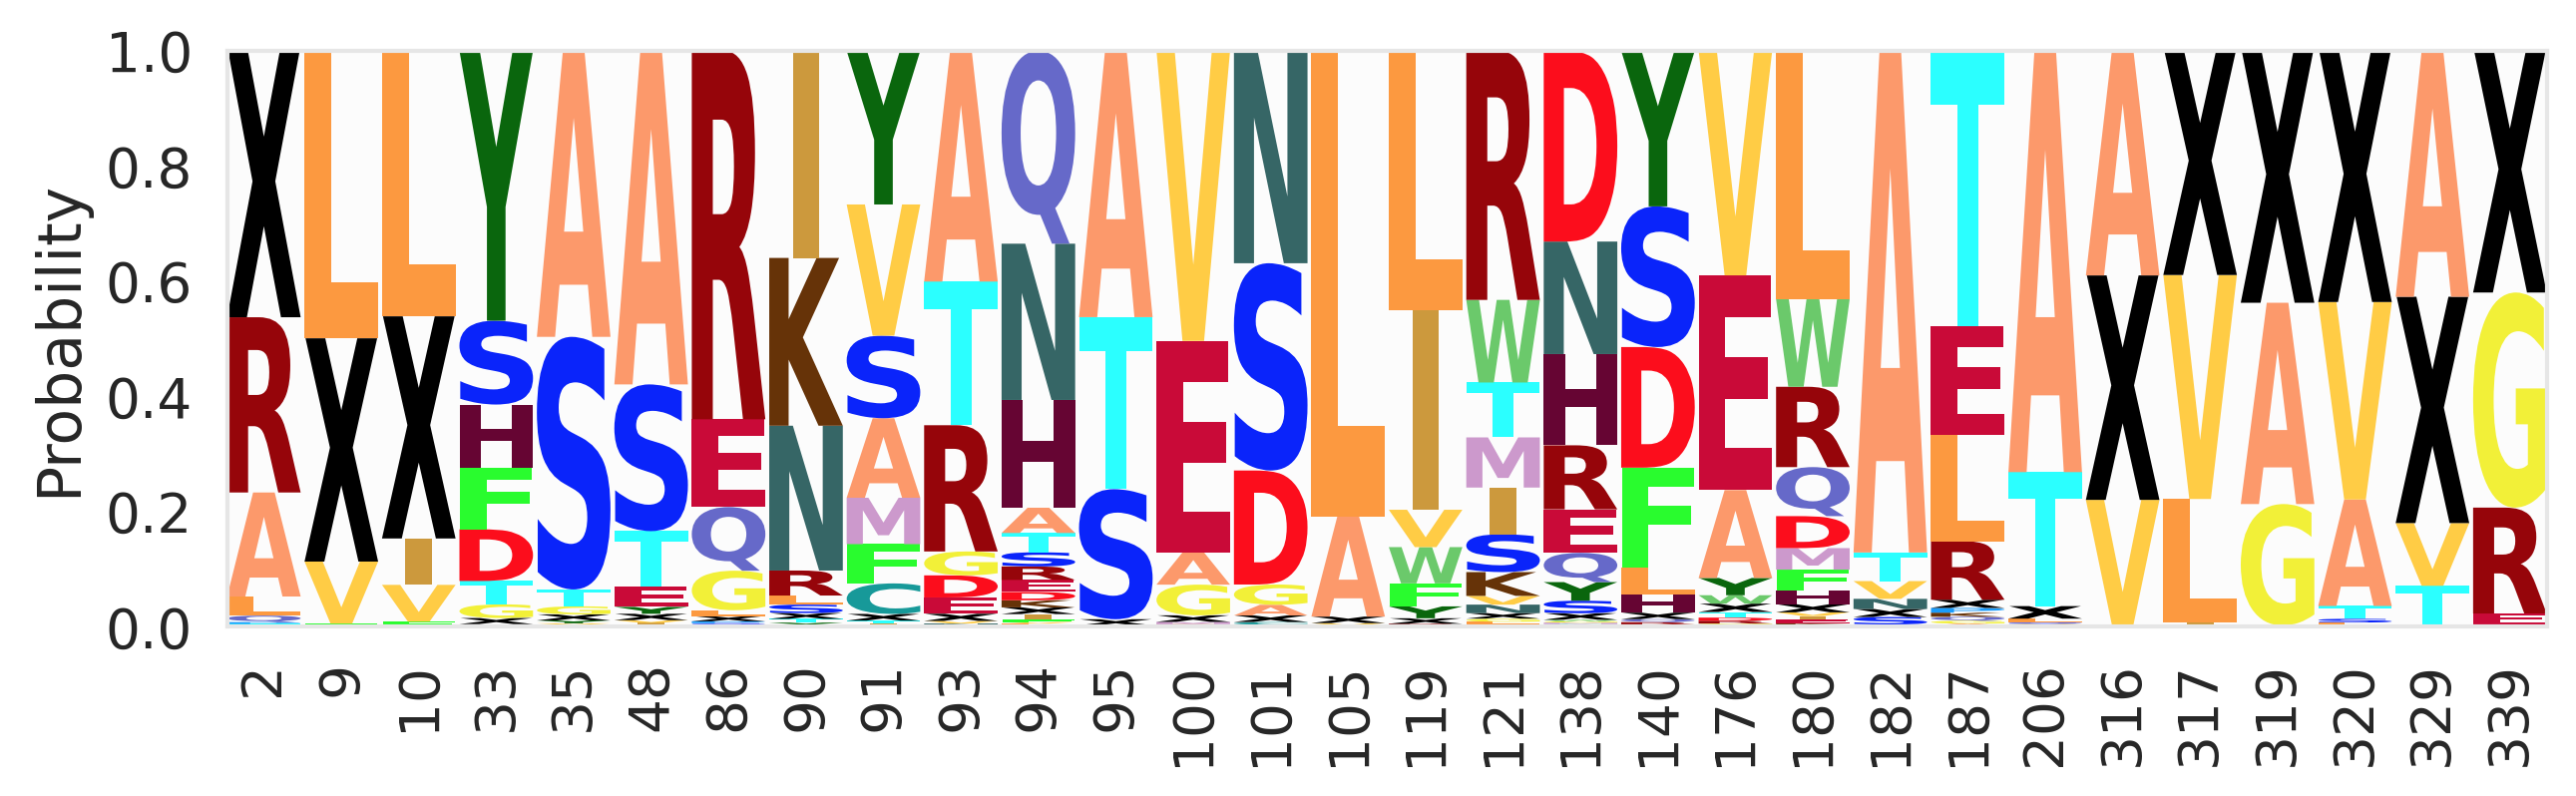

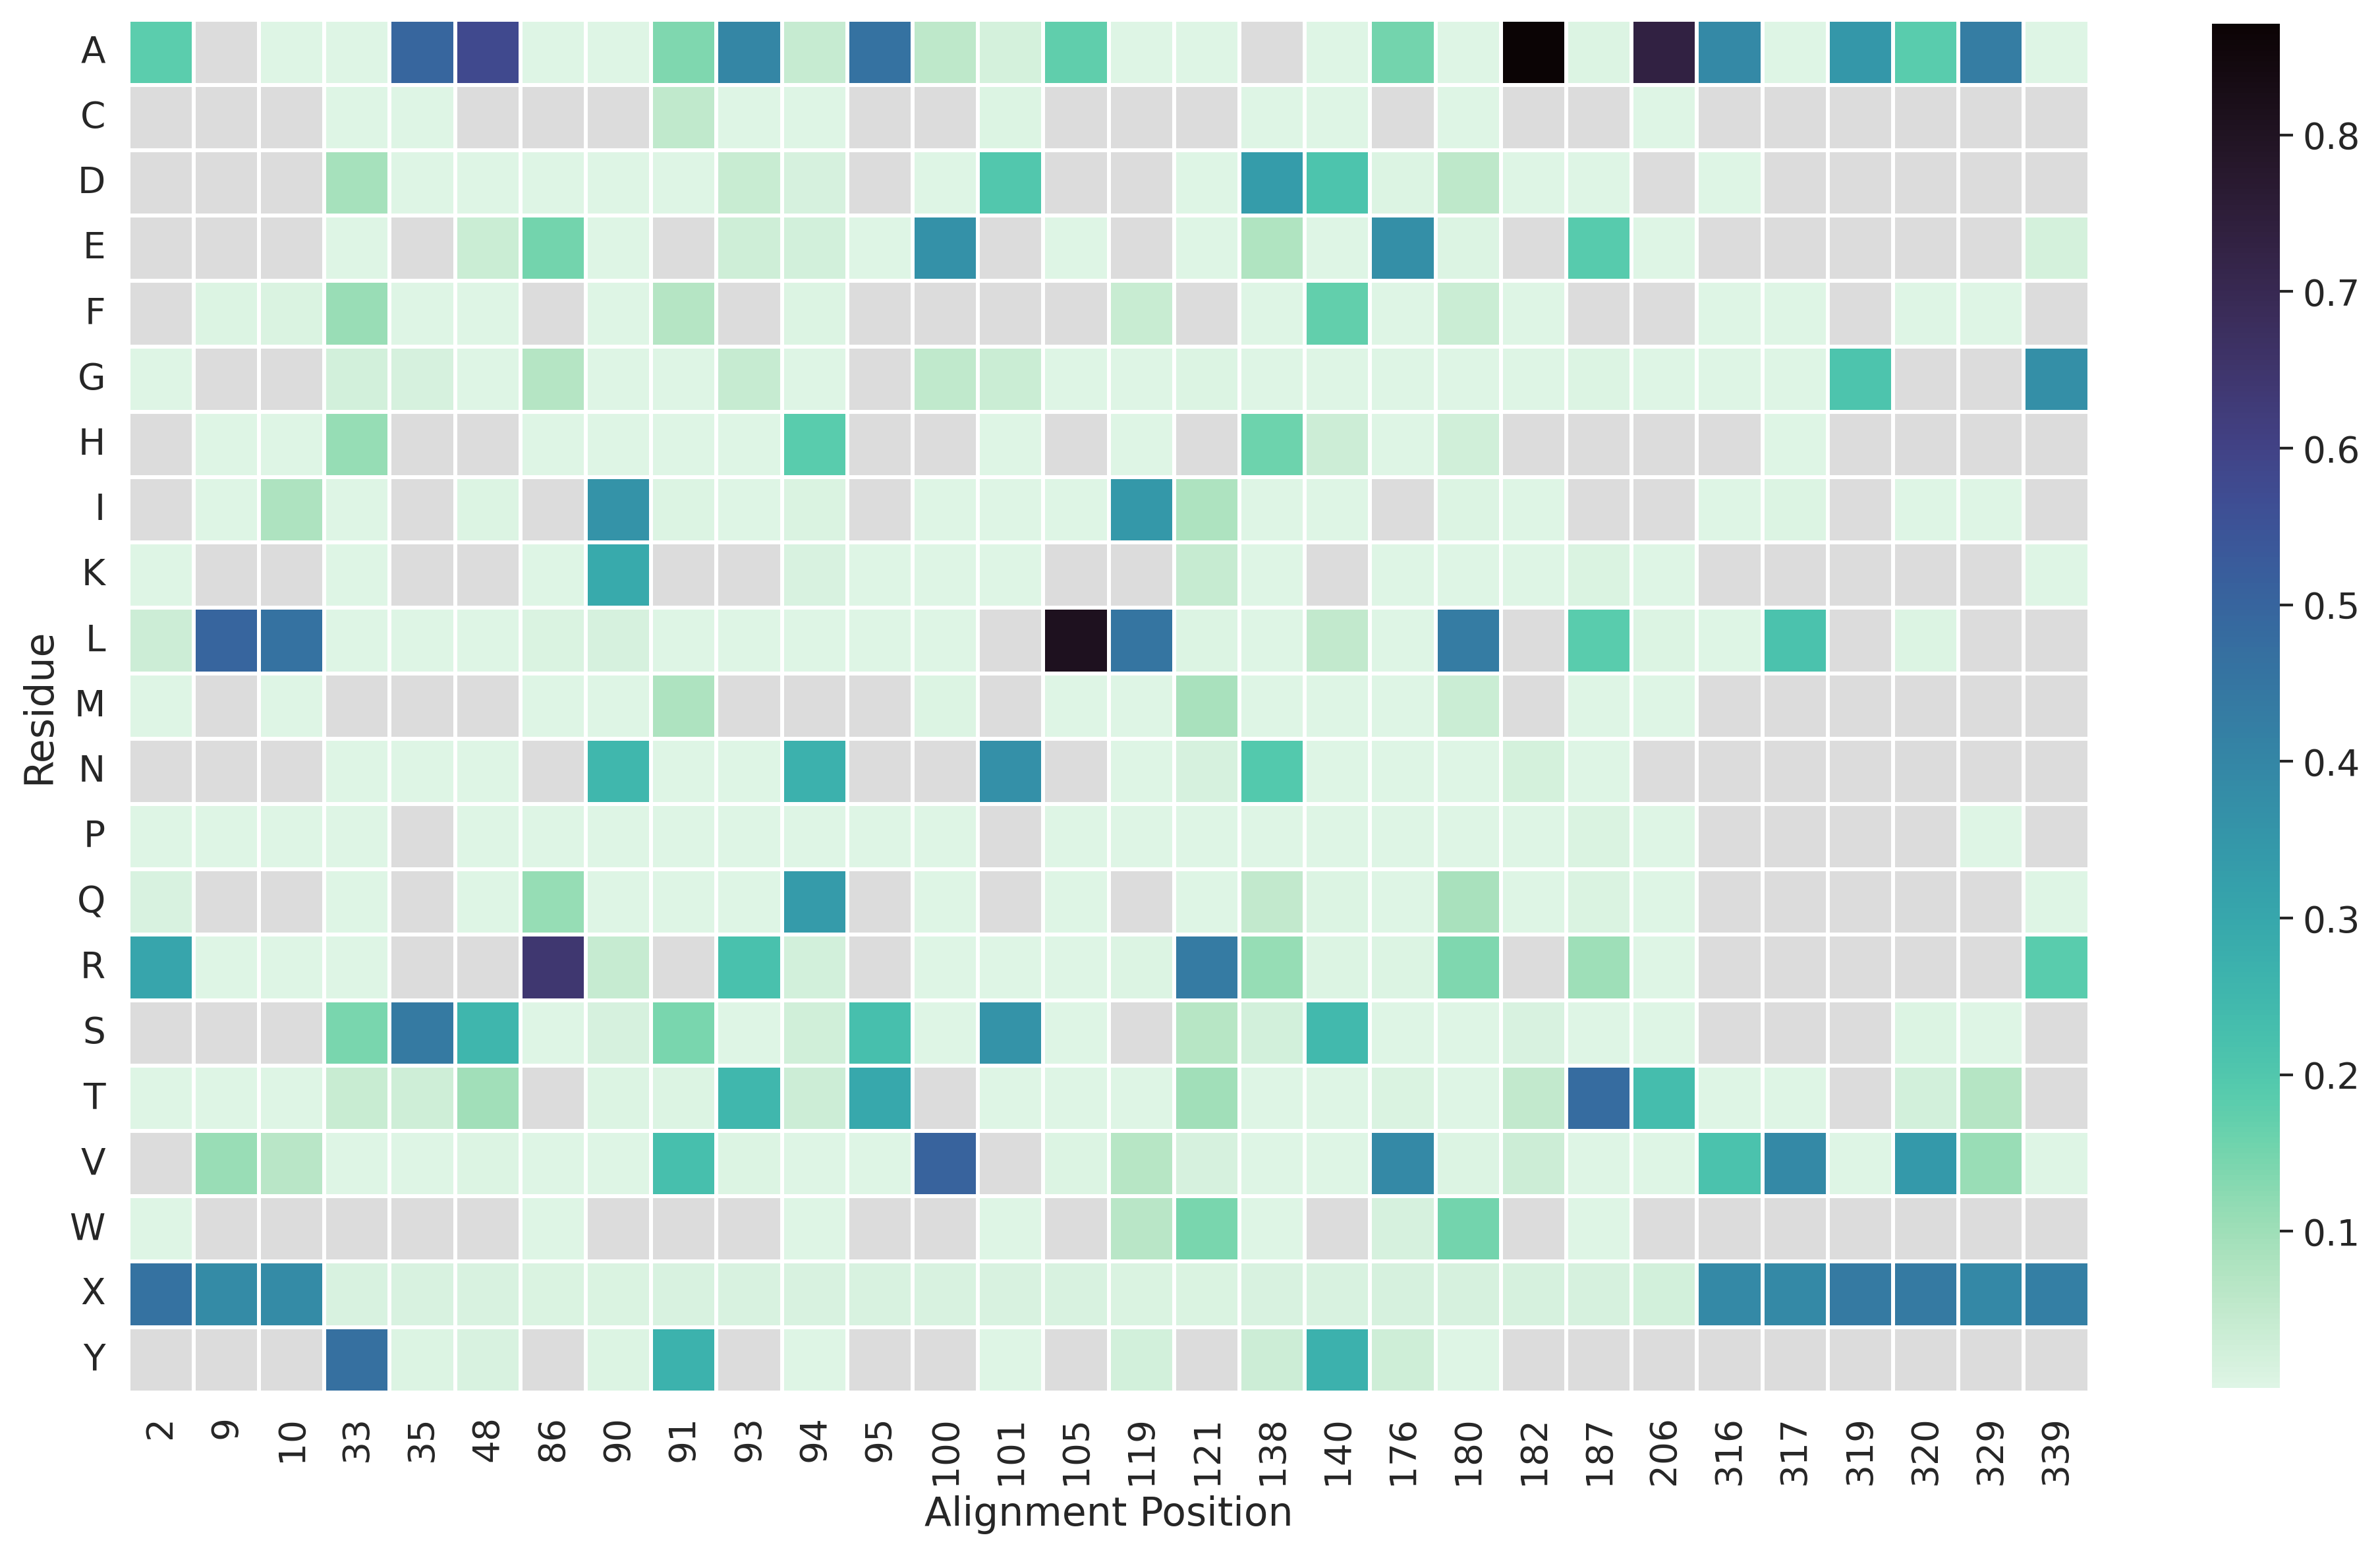

In [11]:
import logomaker as lm


def pseudoseqFig(pseudoseqs, logo):
    pseudosums = pseudoseqs.drop("mhc", axis=1).sum()
    pseudomaps = list()
    for idx in pseudosums.index:
        pseudomaps.append([
            int(idx.split('_')[0]),
            idx.split('_')[1],
            pseudosums.loc[idx] / len(pseudoseqs)])
    pseudomaps = pd.DataFrame(pseudomaps, columns=["Alignment Position","Residue","Probability"])
    pivotcols = pseudomaps.columns
    if not logo:
        pivotcols = [pivotcols[1], pivotcols[0], pivotcols[2]]
    pseudomaps = pseudomaps.pivot(*pivotcols)
    
    pseudomaps.sort_index(level=[0,1], ascending=True, inplace=True)
    
    if logo:
        pseudomaps.fillna(0, inplace=True)
        logo = lm.Logo(
            df=pseudomaps.set_index(np.arange(len(pseudomaps))),
            color_scheme="skylign_protein")
        logo.ax.set_xticks(np.arange(len(pseudomaps)))
        logo.ax.set_xticklabels(pseudomaps.index, rotation=90)
        logo.ax.grid(False)
        logo.ax.set_ylabel("Probability")
        logo.fig.set_dpi(300)
        return logo.fig
    
    fig = plt.figure(figsize=(16,16), dpi=300)
    heatmap = sns.heatmap(
        data=pseudomaps,
        square=True,
        cmap="mako_r",
        cbar_kws={"shrink":0.56},
        linewidth=1)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
    heatmap.set_facecolor("gainsboro")
    
    return fig


with sns.axes_style(style=style, rc=rc):
    logofig = pseudoseqFig(pseudoseqs, True)
    logofig.savefig(os.path.join(savedir,"pseudoseqs_logos.png"), bbox_inches="tight")
    heatmapfig = pseudoseqFig(pseudoseqs, False)
    heatmapfig.savefig(os.path.join(savedir,"pseudoseqs_heatmap.png"), bbox_inches="tight")

In [ ]:
def vizDatasets(dfs, titles):
    
    fig = plt.figure(figsize=(24,28), dpi=300)
    gs = fig.add_gridspec(nrows=len(dfs), ncols=4, hspace=0.20, wspace=0.25)
    ax = gs.subplots()
    
    barcolors = ["firebrick", "royalblue"]
    
    for y,df in enumerate(dfs):
        
        if y < len(dfs) - 1:
            xlabel0 = None
            xlabel1 = None
        else:
            xlabel0 = "MHC Supertype"
            xlabel1 = "Epitope Length"
        
        if not y:
            ax[y][0].set_title("Positives")
            ax[y][1].set_title("Negatives")
            ax[y][2].set_title("Positives")
            ax[y][3].set_title("Negatives")
    
        df["grp"] = df.mhc.apply(lambda x: x[x.index('*')-1])
        grp = df.groupby("grp")
        D = pd.DataFrame({"pos":grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][0], xlabel=xlabel0, ylabel=titles[y], color=barcolors[0], legend=None, width=0.75)
        D = pd.DataFrame({"neg":grp.tgt.count()-grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][1], xlabel=xlabel0, color=barcolors[1], legend=None, width=0.75)

        df["grp"] = df.pep.apply(len)
        grp = df.groupby("grp")
        D = pd.DataFrame({"pos":grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][2], xlabel=xlabel1, color=barcolors[0], legend=None, width=0.75)
        D = pd.DataFrame({"neg":grp.tgt.count()-grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][3], xlabel=xlabel1, color=barcolors[1], legend=None, width=0.75)
        
        for col in range(4):
            ax[y][col].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
            ax[y][col].grid(axis='x')
        
    return fig


with sns.axes_style(style=style, rc=rc):
    datafig = vizDatasets(
        [eltrainval,
         eltest,
         imtrainval,
         imtest,
         iedb],
        ["Eluted Ligand Training and Validation",
         "Eluted Ligand Evaluation",
         "Immunogenicity Training and Validation",
         "Neoepitope Evaluation Dataset",
         "IEDB Infectious Disease Antigens"])
    datafig.suptitle("Composition of Datasets", fontsize=20, y=0.90)
    datafig.savefig(os.path.join(savedir,"datasets.png"), bbox_inches="tight")

In [ ]:
def violins(
    ax,
    results,
    title,
    metricname,
    order,
    setylabel):
    
    sns.violinplot(
        ax=ax,
        data=results,
        x="Method",
        y=metricname,
        cut=0,
        width=0.95,
        linewidth=1,
        scale="width",
        palette=colors,
        order=order)
    
    ax.set(xlabel=None)
    
    ylim = [0, min(1, results[metricname].max() * 1.1)]
    if metricname=="AUROC":
        ylim[0] = min(0.45, results[metricname].min() * 0.9)
    ax.set(ylim=ylim)
        
    ax.tick_params(axis='x', rotation=90)
    
    ax.set(title=title)
    
    if not setylabel:
        ax.set(ylabel=None)
    
    for x,c in enumerate(ax.collections):
        if not (x % 2):
            rgb = c.get_facecolor()[0][:3]
            hls = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
            c.set_edgecolor(colorsys.hls_to_rgb(hls[0], hls[1]/2, hls[2]))


def plotELviolins(
    ax,
    df,
    title,
    metricfunc,
    metricname,
    setylabel):
    
    mhcgrp = df.groupby("mhc")
    algos  = [x for x in df.columns if x in methods]
    results = list()
    
    for mhc in mhcgrp.groups:
        grp = mhcgrp.get_group(mhc).copy()
        T = grp.tgt.to_numpy()
        for algo in algos:
            P = grp[algo].to_numpy()
            results.append([mhc, metricfunc(T, P), methods[algo]])
    
    results = pd.DataFrame(
        columns=["MHC", metricname, "Method"],
        data=results)
    
    order = [
        methods["BigMHC_EL"],
        methods["NetMHCpan-4.1_Ranks"],
        methods["NetMHCpan-4.1_Scores"],
        methods["MixMHCpred-2.1_Ranks"],
        methods["MixMHCpred-2.1_Scores"],
        methods["TransPHLA"],
        methods["MHCnuggets-2.4.0"]]
    
    if metricfunc==auroc:
        y = 0.5
    else:
        y = df.tgt.sum() / df.shape[0]
    x = [-0.5,len(order)-0.25]
    ax.plot(x,[y,y],color="0.75",linestyle=":",linewidth=2)
    
    violins(
        ax=ax,
        results=results,
        title=title,
        metricname=metricname,
        order=order,
        setylabel=setylabel)


with sns.axes_style(style=style, rc=rc):
    
    ela = eltest[eltest.mhc.apply(lambda x: x.startswith("HLA-A"))].copy().reset_index(drop=True)
    elb = eltest[eltest.mhc.apply(lambda x: x.startswith("HLA-B"))].copy().reset_index(drop=True)
    elc = eltest[eltest.mhc.apply(lambda x: x.startswith("HLA-C"))].copy().reset_index(drop=True)

    elviolins = plt.figure(figsize=(18,8), dpi=300)

    gs = elviolins.add_gridspec(nrows=2, ncols=4, hspace=0.15)
    ax = gs.subplots(sharex=True)

    dfs = [eltest, ela, elb, elc]

    titles = [
        "All\n(pos={} neg={})".format(
            int(eltest.tgt.sum()),
            int(eltest.shape[0]-eltest.tgt.sum())),
        "HLA-A\n(pos={} neg={})".format(
            int(ela.tgt.sum()),
            int(ela.shape[0]-ela.tgt.sum())),
        "HLA-B\n(pos={} neg={})".format(
            int(elb.tgt.sum()),
            int(elb.shape[0]-elb.tgt.sum())),
        "HLA-C\n(pos={} neg={})".format(
            int(elc.tgt.sum()),
            int(elc.shape[0]-elc.tgt.sum()))]

    for x in range(4):
            plotELviolins(
                ax=ax[0][x],
                df=dfs[x],
                title=titles[x],
                metricfunc=auroc,
                metricname="AUROC",
                setylabel=(x==0))
            plotELviolins(
                ax=ax[1][x],
                df=dfs[x],
                title=None,
                metricfunc=auprc,
                metricname="AUPRC",
                setylabel=(x==0))

    elviolins.suptitle("Presentation Prediction Results Stratified By MHC", fontsize=20)

    elviolins.savefig(os.path.join(savedir,"el_violins.png" ), bbox_inches="tight")

In [ ]:
import numpy as np

def plotELlines(ax, elL, roc):
    
    if roc:
        order = [
            "BigMHC_EL",
            "TransPHLA",
            "NetMHCpan-4.1_Ranks",
            "NetMHCpan-4.1_Scores",
            "MixMHCpred-2.1_Scores",
            "MixMHCpred-2.1_Ranks",
            "MHCnuggets-2.4.0"]
    else:
        order = [
            "BigMHC_EL",
            "NetMHCpan-4.1_Scores",
            "NetMHCpan-4.1_Ranks",
            "MixMHCpred-2.1_Scores",
            "MixMHCpred-2.1_Ranks",
            "TransPHLA",
            "MHCnuggets-2.4.0"]
    
    results = list()
    
    metricfunc = auroc if roc else auprc
    metricname = "AUROC" if roc else "AUPRC"
    
    for df in elL:
        for col in order:
            res = []
            mhcgrp = df.groupby("mhc")
            for mhc in mhcgrp.groups:
                grp = mhcgrp.get_group(mhc).copy()
                if grp.tgt.sum():
                    res.append(metricfunc(
                        grp.tgt.to_numpy(),
                        grp[col].to_numpy()))
                    results.append([
                        len(grp.pep.iloc[0]),
                        mhc,
                        np.mean(res),
                        methods[col]])
    
    order = [methods[x] for x in order]
    
    results = pd.DataFrame(
        columns=["Peptide Length", "MHC", metricname, "Method"],
        data=results)
    
    means = results.groupby("Method").mean()
    labels = {x:"({:0.4f}) {}".format(means.loc[x][metricname],x) for x in order}
    results.Method = results.Method.apply(lambda x: labels[x])
    
    ax.set_xlim([7.98, 14.02])
    ax.set_ylim([(0.50 if roc else 0), 1])
    
    sns.lineplot(
        ax=ax,
        data=results,
        x=results.columns[0],
        y=metricname,
        hue="Method",
        linewidth=2,
        errorbar=("ci", 95),
        palette=[colors[x] for x in order])
    
    if not roc:
        baselineResults = list()
        for df in elL:
            mhcgrp = df.groupby("mhc")
            for mhc in mhcgrp.groups:
                grp = mhcgrp.get_group(mhc).copy()
                if grp.tgt.sum():
                    baselineResults.append([
                        len(grp.pep.iloc[0]),
                        grp.tgt.sum() / len(grp.tgt)])
        baselineResults = pd.DataFrame(
            columns=["Peptide Length", "baseline"],
            data=baselineResults)
        sns.lineplot(
            ax=ax,
            data=baselineResults,
            x=baselineResults.columns[0],
            y=baselineResults.columns[1],
            errorbar=("ci", 95),
            color="0.75",
            linestyle=":",
            linewidth=2)

    ax.legend()
    hdls = list()
    for hdl in ax.get_legend().legendHandles:
        hdl.set_linewidth(4)
        hdls.append(hdl)
    ax.legend(
        handles=hdls,
        title="Mean AU" + ("ROC" if roc else "PRC"),
        loc=(0.06,0.17),
        borderpad=0.35,
        labelspacing=0.25,
        framealpha=0.35,
        fontsize=11)


with sns.axes_style(style=style, rc=rc):
    
    elL = [eltest[eltest["pep"].apply(len)==x] for x in range(8,15)]
    
    ellines = plt.figure(figsize=(18,8), dpi=300)

    gs = ellines.add_gridspec(nrows=1, ncols=2, hspace=0.15)
    ax = gs.subplots(sharex=True)

    plotELlines(ax[0], elL, True)
    plotELlines(ax[1], elL, False)

    ellines.suptitle("Presentation Prediction Results Stratified by MHC and Peptide Length", fontsize=20)

    ellines.savefig(os.path.join(savedir,"el_lines.png" ), bbox_inches="tight")

In [ ]:
def plotELscatter(ax, df, roc):
    
    order = [
        "BigMHC_EL",
        "NetMHCpan-4.1_Ranks",
        "NetMHCpan-4.1_Scores",
        "MixMHCpred-2.1_Ranks",
        "MixMHCpred-2.1_Scores",
        "TransPHLA",
        "MHCnuggets-2.4.0"]
    
    order = [methods[x] for x in order]
    
    results = list()
    
    mhcgrp = df.groupby("mhc")
    algos  = [x for x in df.columns if x in methods]
    results = list()
    
    metricfunc = auroc if roc else auprc
    metricname = "AUROC" if roc else "AUPRC"
    
    for mhc in sorted(mhcgrp.groups):
        grp = mhcgrp.get_group(mhc).copy()
        T = grp.tgt.copy().to_numpy()
        for algo in algos:
            P = grp[algo].copy().to_numpy()
            results.append([mhc, metricfunc(T,P), methods[algo]])
    
    results = pd.DataFrame(
        columns=["MHC", metricname, "Method"],
        data=results)
    
    means = results.groupby("Method").mean()
    labels = {x:"({:0.4f}) {}".format(means.loc[x][metricname],x) for x in order}
    results.Method = results.Method.apply(lambda x: labels[x])
    palette = [colors[x] for x in order]
    order = [labels[k] for k in order]
    
    sns.scatterplot(
        ax=ax,
        data=results,
        x=results.columns[1],
        y=results.columns[0],
        hue=results.columns[2],
        palette=palette,
        hue_order=order,
        style_order=order,
        size_order=order,
        style="Method",
        markers=['x',"|","_",'1','2','4','+'],
        size="Method",
        sizes=[75,75,75,75,75,75,75],
        linewidth=2.5)
    
    if roc:
        ax.set_xlim([0.7,1])
        ax.tick_params(
            left=True,
            right=True,
            labelleft=True,
            labelright=True,
            labelsize=10)
    else:
        ax.set_xlim([0,1])
        ax.set_ylabel(None)
        ax.tick_params(
            left=True,
            labelleft=False,
            right=True,
            labelright=True,
            labelsize=10)
    
    leg = ax.legend(
        title="Mean AU" + ("ROC" if roc else "PRC"),
        borderpad=0.35,
        labelspacing=0.35,
        framealpha=0.35)
    
    for marker in leg.legendHandles:
        marker.set_linewidth(2.5)


with sns.axes_style(style=style, rc=rc):
    
    elscatter = plt.figure(figsize=(16,8), dpi=300)

    gs = elscatter.add_gridspec(nrows=1, ncols=2)
    ax = gs.subplots()

    plotELscatter(ax[0], eltest, True)
    plotELscatter(ax[1], eltest, False)
    
    elscatter.savefig(os.path.join(savedir,"el_scatter.png" ), bbox_inches="tight")

In [ ]:
import numpy as np
import scipy.stats as st


def pvals(df, xcol, ycol, target, order):
    groups = df.groupby(xcol)
    results = list()
    comparisons = len(order) - int(target in order)
    for method in order:
        if method == target:
            continue
        pval = st.wilcoxon(
            groups.get_group(target)[ycol],
            groups.get_group(method)[ycol]).pvalue
        results.append([method, pval * comparisons])
    return pd.DataFrame(
        data=results,
        columns=["Method","pval"]).set_index("Method")


def bars(
    ax,
    df,
    xcol,
    ycol,
    ythresh,
    order,
    target=None,
    title=None,
    ylabel=None,
    xlabel=True,
    ylim=None):
    
    df[ycol] -= ythresh
    
    haserr = len(df) > len(order)
    
    groups = df.groupby(xcol)
    means = groups.mean()[ycol].reindex(order)
    std = groups.std()[ycol].reindex(order)
    ci95 = 1.96 * std / np.sqrt(groups.size()).reindex(order)
    
    sns.barplot(
        ax=ax,
        data=df,
        x=xcol,
        y=ycol,
        order=order,
        palette=[colors[x] for x in order],
        width=0.80,
        errwidth=1,
        capsize=0.25)
    
    if not xlabel:
        ax.set(xticklabels=[])
    
    if ylabel:
        ax.set_ylabel(ylabel)
        
    if title:
        ax.set_title(title)

    ax.set_xlabel(None)
    ax.grid(axis='x')
    ax.tick_params(axis='x', rotation=90)
    
    if len(df) == len(order):
        ymax = means.max()
        ymin = means.min()
    else:
        ymax = (means + ci95).max()
        ymin = (means - ci95).min()

    if ylim:
        ylim = [ylim[0] - ythresh, ylim[1] - ythresh]
    else:
        ylim = list()
        ypad = (ymax - ymin) / 20
        if ymin > 0:
            ylim.append(0)
        else:
            ylim.append(ymin - ypad)
        if ymax > (0.90 - ythresh):
            ylim.append(1.001 - ythresh)
        else:
            ylim.append(min(ymax + ypad, 1.001 - ythresh))
    tickstep = (ylim[1]-ylim[0]) / 10
    if tickstep > 0.05:
        tickstep = np.round(tickstep / 0.05) * 0.05
    yticks = list(np.arange(ylim[0], ylim[1], tickstep))
    if ylim[1] > 0.90:
        yticks.append(1 - ythresh)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["{:0.2f}".format(y + ythresh) for y in ax.get_yticks()])
    
    ax.xaxis.grid(False)
    
    def _darker(patch):
        rgb = patch.get_facecolor()[:3]
        hls = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
        return colorsys.hls_to_rgb(hls[0], hls[1]/2, hls[2])
    
    darkcolors = list()
    
    for patch in ax.patches:
        rgb = patch.get_facecolor()[:3]
        hls = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
        darkcolor = colorsys.hls_to_rgb(hls[0], hls[1]/2, hls[2])
        darkcolors.append(darkcolor)
        patch.set_edgecolor(darkcolor)
    
    if haserr:
        for x, line in enumerate(ax.get_lines()):
            line.set_color(darkcolors[x // 3])
        
        if target is not None:
            sigs = pvals(df, xcol, ycol, target, order)
            dy = 0
            targetidx = order.index(target)
            ytarget = (means + ci95)[target]
            for x, method in enumerate(order):
                if method == target:
                    continue
                ymethod = (means + ci95)[method]
                dy += 0.03
                ybar = max(ytarget, ymethod) + (dy * (ylim[1] - ylim[0]))
                dbar = (0.01 * (ylim[1] - ylim[0]))
                ax.plot(
                    [targetidx, targetidx, x, x],
                    (dbar + np.array([
                        ybar - dbar, ybar, ybar, ymethod])),
                    c=darkcolors[x],
                    linewidth=0.5)

                ax.text(
                    abs(x - targetidx)/2,
                    ybar+dbar,
                    "p={:.1e}".format(sigs.loc[method].pval),
                    fontsize=8,
                    ha="center",
                    va="bottom")
                
                ylim[1] = max(ylim[1], ybar + dbar + 0.03)
    
    ax.set_ylim(ylim)
    
    ax.axhline(0, linewidth=1, color="gray")

In [ ]:
def plotELbars(ax, df, roc, stratlen):
    
    if stratlen:
        df["len"] = df.pep.apply(len)
        groups = df.groupby(["mhc","len"])
    else:
        groups = df.groupby("mhc")
    
    order = [
        "BigMHC_EL",
        "NetMHCpan-4.1_Ranks",
        "NetMHCpan-4.1_Scores",
        "MixMHCpred-2.1_Ranks",
        "MixMHCpred-2.1_Scores",
        "TransPHLA",
        "MHCnuggets-2.4.0"]
    
    results = list()
    
    order = [x for x in order if x in df.columns]
    
    metricfunc = auroc if roc else auprc
    metricname = "AUROC" if roc else "AUPRC"
    
    randauprc = list()
    for key in groups.groups:
        grp = groups.get_group(key)
        T = grp.tgt.to_numpy()
        if not T.sum():
            continue
        for algo in order:
            P = grp[algo].to_numpy()
            results.append([key, metricfunc(T,P), methods[algo]])
        randauprc.append(T.sum() / len(T))
    randauprc = sum(randauprc) / len(randauprc)
    
    results = pd.DataFrame(
        columns=["MHC", metricname, "Method"],
        data=results)
    
    title = "Mean {}\nStratified by {}".format(
        metricname,
        "MHC and Peptide Length" if stratlen else "MHC")
    
    ythresh = 0.5 if roc else randauprc
    bars(
        ax=ax,
        df=results,
        xcol="Method",
        ycol=metricname,
        ythresh=ythresh,
        title=title,
        ylabel=metricname,
        target=methods["BigMHC_EL"],
        order=[methods[x] for x in order],
        ylim=[ythresh, 1.001],
        xlabel=((not roc) and stratlen))
    
    print(pvals(
        df=results,
        xcol="Method",
        ycol=metricname,
        target=methods["BigMHC_EL"],
        order=[methods[x] for x in order]))


with sns.axes_style(style=style, rc=rc):
    
    elbars = plt.figure(figsize=(5,28), dpi=300)

    gs = elbars.add_gridspec(nrows=4, ncols=1, hspace=0.15)
    ax = gs.subplots()
    
    plotELbars(ax[0], eltest, True,  False)
    plotELbars(ax[1], eltest, False, False)
    plotELbars(ax[2], eltest, True,  True)
    plotELbars(ax[3], eltest, False, True)
    
    elbars.savefig(os.path.join(savedir,"el_bars.png" ), bbox_inches="tight")

In [ ]:
def plotImmunoPPV(lineax, barax, df, title, neo):
    
    order = [
        "BigMHC_EL",
        "BigMHC_IM",
        "BigMHC_ELIM",
        "PRIME-2.0_Scores",
        "PRIME-2.0_Ranks",
        "MixMHCpred-2.2_Scores",
        "MixMHCpred-2.2_Ranks",
        "MHCflurry-2.0_Scores",
        "MHCflurry-2.0_Ranks",
        "TransPHLA",
        "MHCnuggets-2.4.0",
        "NetMHCpan-4.1_Scores",
        "NetMHCpan-4.1_Ranks",
        "HLAthena_Scores",
        "HLAthena_Ranks"]
    
    title = title + "\n(pos={} neg={})".format(df["tgt"].sum(), df.shape[0]-df["tgt"].sum())
    
    results = list()
    
    T = df.tgt
    tsum = int(T.sum())
    
    miny = 1
    maxy = 0
    
    lineax.axhline(
        y=tsum / len(T),
        linewidth=1,
        color="gray")
    
    for col in order[::-1]:
        
        if col not in df.columns:
            continue
            
        idx = np.argsort(df[col])[::-1]
        
        x = np.arange(1,tsum+1)
        y = np.cumsum(T[idx[:tsum]]) / x
        
        for _y in y:
            results.append([methods[col],_y])
        
        miny = min(miny, y.mean())
        maxy = max(maxy, y.mean())
        
        lineax.plot(
            x,
            y,
            color=colors[methods[col]],
            linewidth=1,
            label=methods[col])
    
    results = pd.DataFrame(
        data=results[::-1],
        columns=["Method","PPVn"])
    
    print(pvals(
        results,
        xcol="Method",
        ycol="PPVn",
        target=methods["BigMHC_IM"],
        order=[methods[x] for x in order]))
    
    ythresh = (tsum / T.shape[0])
    
    bars(
        ax=barax,
        df=results,
        xcol="Method",
        ycol="PPVn",
        ythresh=ythresh,
        ylabel="Mean PPVn",
        order=[methods[x] for x in order])
    barax.set_xlabel(None)
    
    ypad = ((maxy-miny) / 5)
    lineax.set_ylim([max(-0.005, miny - 4*ypad), 1.005])
    lineax.set_xlim([1,tsum])
    
    lineax.set_title(title)
    # set legend position to the right of precisions line plot
    # and reverse the legend label order
    lineax.legend()
    hdls = list()
    for hdl in lineax.get_legend().legendHandles:
        hdl.set_linewidth(4)
        hdls.append(hdl)
    lineax.legend(
        handles=hdls[::-1],
        bbox_to_anchor=(0.17, 1.015),
        fontsize=10,
        borderpad=0.35,
        labelspacing=0.20,
        ncol=2)
    lineax.set_xlabel("Number of Top Predictions (n)")
    lineax.set_ylabel("PPVn")


with sns.axes_style(style=style, rc=rc):

    immunoppv = plt.figure(figsize=(16,12), dpi=300)

    gs = immunoppv.add_gridspec(nrows=2, ncols=2, hspace=0.20, wspace=0.30)
    ax = gs.subplots()
    
    plotImmunoPPV(ax[0][0], ax[1][0], imtest, title="Neoepitopes", neo=True)
    
    plotImmunoPPV(ax[0][1], ax[1][1], iedb, title="IEDB Infectious Disease Antigens", neo=False)
    
    immunoppv.savefig(os.path.join(savedir,"immuno_precision.png" ), bbox_inches="tight")

In [ ]:
def bootstrapIndices(n, k):
    np.random.seed(1)
    indices = np.arange(n)
    return [np.random.choice(indices, n) for _ in range(k)]

def bootstrapAUC(method, T, P, indices):
    results = list()
    for idx in indices:
        t = T[idx]
        if (0 in t) and (1 in t):
            p = P[idx]
            results.append([method, auroc(t,p), auprc(t,p)])
    return pd.DataFrame(columns=["Method","AUROC","AUPRC"], data=results)


def plotImmunoBars(dfs, titles):
    
    order = [
        "BigMHC_EL",
        "BigMHC_IM",
        "BigMHC_ELIM",
        "PRIME-2.0_Scores",
        "PRIME-2.0_Ranks",
        "MixMHCpred-2.2_Scores",
        "MixMHCpred-2.2_Ranks",
        "MHCflurry-2.0_Scores",
        "MHCflurry-2.0_Ranks",
        "TransPHLA",
        "MHCnuggets-2.4.0",
        "NetMHCpan-4.1_Scores",
        "NetMHCpan-4.1_Ranks",
        "HLAthena_Scores",
        "HLAthena_Ranks"]

    immunobars = plt.figure(figsize=(16,12), dpi=300)

    gs = immunobars.add_gridspec(nrows=len(dfs), ncols=2, hspace=0.10, wspace=0.30)
    ax = gs.subplots(sharex="col")
    
    for x, df in enumerate(dfs):
        indices = bootstrapIndices(len(df), 1000)
        results = list()
        for col in [c for c in order if c in df.columns]:
            results.append(bootstrapAUC(methods[col], df.tgt, df[col], indices))
        results = pd.concat(results)
        
        bars(
            ax=ax[0][x],
            df=results,
            xcol="Method",
            ycol="AUROC",
            ythresh=0.50,
            order=[methods[x] for x in order],
            ylabel="AUROC",
            title=(
                titles[x] + "\n(pos={} neg={})".format(
                    df.tgt.sum(), df.shape[0]-df.tgt.sum())))
        bars(
            ax=ax[1][x],
            df=results,
            xcol="Method",
            ycol="AUPRC",
            ythresh=(df.tgt.sum() / df.shape[0]),
            order=[methods[x] for x in order],
            ylabel="AUPRC")
    
    return immunobars


with sns.axes_style(style=style, rc=rc):
    immunobars = plotImmunoBars(
        [imtest, iedb],
        ["Neoepitopes", "IEDB Infectious Disease Antigens"])
    immunobars.savefig(os.path.join(savedir,"immuno_bars.png" ), bbox_inches="tight")